# Robust Linear Models

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

## Estimation

Load data:

In [3]:
data = sm.datasets.stackloss.load(as_pandas=False)
data.exog = sm.add_constant(data.exog)

Huber's T norm with the (default) median absolute deviation scaling

In [4]:
huber_t = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print(hub_results.params)
print(hub_results.bse)
print(hub_results.summary(yname='y',
            xname=['var_%d' % i for i in range(len(hub_results.params))]))

[-41.02649835   0.82938433   0.92606597  -0.12784672]
[9.79189854 0.11100521 0.30293016 0.12864961]
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 21 Feb 2020                                         
Time:                        13:56:28                                         
No. Iterations:                    19                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

Huber's T norm with 'H2' covariance matrix

In [5]:
hub_results2 = huber_t.fit(cov="H2")
print(hub_results2.params)
print(hub_results2.bse)

[-41.02649835   0.82938433   0.92606597  -0.12784672]
[9.08950419 0.11945975 0.32235497 0.11796313]


Andrew's Wave norm with Huber's Proposal 2 scaling and 'H3' covariance matrix

In [6]:
andrew_mod = sm.RLM(data.endog, data.exog, M=sm.robust.norms.AndrewWave())
andrew_results = andrew_mod.fit(scale_est=sm.robust.scale.HuberScale(), cov="H3")
print('Parameters: ', andrew_results.params)

Parameters:  [-40.8817957    0.79276138   1.04857556  -0.13360865]


See ``help(sm.RLM.fit)`` for more options and ``module sm.robust.scale`` for scale options

## Comparing OLS and RLM

Artificial data with outliers:

In [7]:
nsample = 50
x1 = np.linspace(0, 20, nsample)
X = np.column_stack((x1, (x1-5)**2))
X = sm.add_constant(X)
sig = 0.3   # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta)
y2 = y_true2 + sig*1. * np.random.normal(size=nsample)
y2[[39,41,43,45,48]] -= 5   # add some outliers (10% of nsample)

### Example 1: quadratic function with linear truth

Note that the quadratic term in OLS regression will capture outlier effects. 

In [8]:
res = sm.OLS(y2, X).fit()
print(res.params)
print(res.bse)
print(res.predict())

[ 5.11003863  0.5285205  -0.01374639]
[0.45516517 0.07027136 0.00621793]
[ 4.76637875  5.03591903  5.30087908  5.56125892  5.81705852  6.06827791
  6.31491707  6.55697601  6.79445472  7.02735321  7.25567148  7.47940952
  7.69856735  7.91314494  8.12314232  8.32855947  8.5293964   8.7256531
  8.91732959  9.10442585  9.28694188  9.46487769  9.63823328  9.80700865
  9.97120379 10.13081871 10.28585341 10.43630788 10.58218213 10.72347616
 10.86018996 10.99232354 11.1198769  11.24285003 11.36124294 11.47505563
 11.58428809 11.68894033 11.78901235 11.88450414 11.97541572 12.06174706
 12.14349819 12.22066909 12.29325977 12.36127022 12.42470045 12.48355046
 12.53782025 12.58750981]


Estimate RLM:

In [9]:
resrlm = sm.RLM(y2, X).fit()
print(resrlm.params)
print(resrlm.bse)

[ 5.04611616e+00  5.11413247e-01 -2.69305305e-03]
[0.13964091 0.02155867 0.00190761]


Draw a plot to compare OLS estimates to the robust estimates:

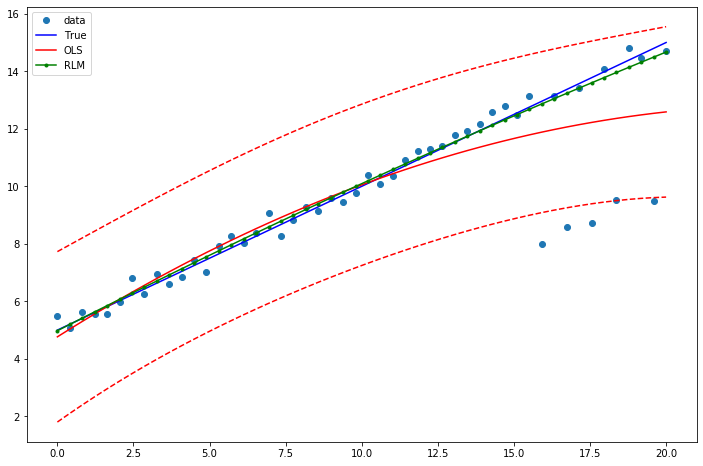

In [10]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, 'o',label="data")
ax.plot(x1, y_true2, 'b-', label="True")
prstd, iv_l, iv_u = wls_prediction_std(res)
ax.plot(x1, res.fittedvalues, 'r-', label="OLS")
ax.plot(x1, iv_u, 'r--')
ax.plot(x1, iv_l, 'r--')
ax.plot(x1, resrlm.fittedvalues, 'g.-', label="RLM")
ax.legend(loc="best")

### Example 2: linear function with linear truth

Fit a new OLS model using only the linear term and the constant:

In [11]:
X2 = X[:,[0,1]]
res2 = sm.OLS(y2, X2).fit()
print(res2.params)
print(res2.bse)

[5.66410251 0.39105655]
[0.39504002 0.03403825]


Estimate RLM:

In [12]:
resrlm2 = sm.RLM(y2, X2).fit()
print(resrlm2.params)
print(resrlm2.bse)

[5.13515772 0.48757594]
[0.10878613 0.00937345]


Draw a plot to compare OLS estimates to the robust estimates:

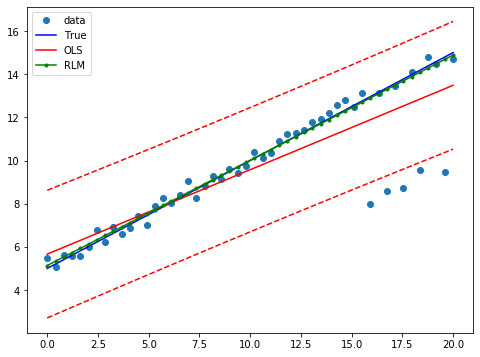

In [13]:
prstd, iv_l, iv_u = wls_prediction_std(res2)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x1, y2, 'o', label="data")
ax.plot(x1, y_true2, 'b-', label="True")
ax.plot(x1, res2.fittedvalues, 'r-', label="OLS")
ax.plot(x1, iv_u, 'r--')
ax.plot(x1, iv_l, 'r--')
ax.plot(x1, resrlm2.fittedvalues, 'g.-', label="RLM")
legend = ax.legend(loc="best")